In [1]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training
import torch
from torchvision import datasets, transforms
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import torchvision
import random

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

import torch.nn as nn

import torch.nn.functional as F
import sys
import os
import seaborn as sns
from torchsummary import summary
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

sns.set(style='darkgrid', palette='muted', font_scale=1.5)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [3]:
from netcal.metrics import ECE
from laplace.utils import ModuleNameSubnetMask

In [4]:
import torch.distributions as dists


In [5]:
py_file_location = "/Users/georgioszefkilis/Bayesian_Deep_Learning/src/utils"
sys.path.append(os.path.abspath(py_file_location))

In [6]:
py_file_location_src = "/Users/georgioszefkilis/Bayesian_Deep_Learning/src/data"
sys.path.append(os.path.abspath(py_file_location_src))

In [7]:
import make_dataset
import AffineTransform
from AffineTransform import make_affine_parameters
import compute_dim
from compute_dim import compute_conv_dim,compute_pool_dim
import SaveLoad
from SaveLoad import save_ckp

In [8]:
if torch.cuda.is_available():
      print("The code will run on GPU.")
else:
      print("The code will run on CPU.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The code will run on CPU.


In [9]:
config={
            "batch_size": 256,
            "num_classes": 10,
            "channels": 1,
            "filter1_out": 16,
            "kernel_size": 5,
            "pool": 2,
            "filter2_out": 32,
            "padding": 0,
            "stride": 1,
            "learning_rate_base": 0.001,
            "learning_rate_stn":0.0001,
            "epochs": 5,
            "crop_size": 128,
            "enc_sizes":[16,32],
            "loc_sizes":[8,10],
        }


In [10]:
train_loader,_,test_loader = make_dataset.data(config["batch_size"],config["crop_size"],misplacement=False,load=True,save=False)

Getting MNIST
Train_data 42000
Validation_data 18000
Test_data 10000


Feature batch shape: torch.Size([256, 1, 28, 28])
Labels batch shape: torch.Size([256])


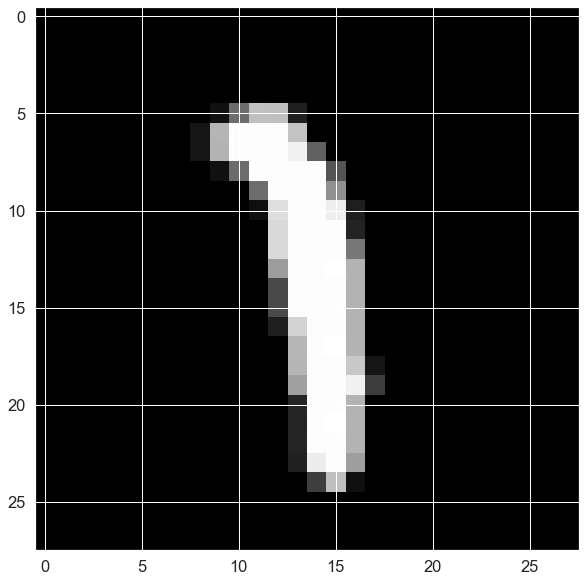

Label: 1


In [11]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [12]:
def conv_block(in_f, out_f, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, *args, **kwargs),
        nn.MaxPool2d(2, stride=2),
        nn.BatchNorm2d(out_f),
        nn.ReLU()
    )


class Base(nn.Module):
    def __init__(self, enc_sizes,kernel,pad):
        super().__init__()

        conv_blocks =[conv_block(in_f, out_f, kernel_size=kernel, padding=pad) 
                       for in_f, out_f in zip(enc_sizes, enc_sizes[1:])]

        self.base_net = nn.Sequential(*conv_blocks)
        

    def forward(self,x):
        x = self.base_net(x)
    
        return x


class STN(nn.Module):
    def __init__(self,loc_sizes,kernel,pad, parameterize=True):
        super().__init__()
    
        self.parameterize =parameterize 
        self.loc_sizes = loc_sizes
        
        
        conv_blocks =[conv_block(in_f, out_f, kernel_size=kernel, padding=pad) 
                        for in_f, out_f in zip(loc_sizes, loc_sizes[1:])]

        self.localization = nn.Sequential(*conv_blocks)
        

        # Regressor for the affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(loc_sizes[-1] * 4 * 4, 32),
            nn.ReLU(),
            nn.Linear(32, 2 * 1 if parameterize else 3 * 2),
        )
        
        self.fc_loc[-1].weight.data.zero_()
        if parameterize:
            bias = torch.tensor([0, 0], dtype=torch.float)
            self.fc_loc[-1].bias.data.copy_(bias[:2].view(-1))

        else:
            self.fc_loc[-1].bias.data.copy_(
                torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float)
            )
        

    def forward(self,x):
        xs = self.localization(x)
        #print(xs.shape)
        xs = xs.view(-1, self.loc_sizes[-1] * xs.shape[2] * xs.shape[3])

        theta = self.fc_loc(xs)

        if self.parameterize:
            theta = AffineTransform.make_affine_parameters(theta)
        else:
            theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid)

        return x

class Net(nn.Module):
    def __init__(self, in_c, enc_sizes, loc_sizes,kernel,pad, n_classes,parameterize=True):
        super().__init__()
    
        self.enc_sizes = [in_c, *enc_sizes]
        self.loc_sizes = [in_c, *loc_sizes]
        self.kernel = kernel
        self.pad =pad

        self.parameterize = parameterize
        self.n_classes = n_classes
        
        self.base = Base(self.enc_sizes, self.kernel, self.pad)
        self.stn = STN(self.loc_sizes, self.kernel, self.pad, self.parameterize)
        self.fc1 = nn.Linear(
            self.enc_sizes[-1] * 4* 4 , 50
        )
        self.fc2 = nn.Linear(50, self.n_classes)
        

    def forward(self,x):
        # transform the input
        #print('input_stn',x.shape)
        x = self.stn(x)
        #print('stn_out',x.shape)

        x = self.base(x)
        #print('out_base',x.shape)
        
        #x = x.view(-1, self.enc_sizes[-1] * 4 * 4)
        x = x.flatten(1)
        #print('exp',y.shape)
        #print('flat',x.shape)
        x = F.relu(self.fc1(x))
        #print('linea_out',x.shape)
        
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #print('net_out',x.shape)

        return x



In [13]:
model = Net(
        config["channels"],
        config["enc_sizes"],
        config["loc_sizes"],
        config["kernel_size"],
        config["padding"],
        config["num_classes"],
        parameterize=False).to(device).eval()

In [14]:
#model_path = '/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/STN_MNIST_10_HPC.pth'
model_path = '/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/colab_best_MNIST_20_STN2__ver_2lr.pth'

checkpoint = torch.load(model_path, map_location=device)
    # initialize state_dict from checkpoint to model
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [15]:
[ (name,np.prod(p.size())) for name,p in model.named_parameters() if p.requires_grad]

[('base.base_net.0.0.weight', 400),
 ('base.base_net.0.0.bias', 16),
 ('base.base_net.0.2.weight', 16),
 ('base.base_net.0.2.bias', 16),
 ('base.base_net.1.0.weight', 12800),
 ('base.base_net.1.0.bias', 32),
 ('base.base_net.1.2.weight', 32),
 ('base.base_net.1.2.bias', 32),
 ('stn.localization.0.0.weight', 200),
 ('stn.localization.0.0.bias', 8),
 ('stn.localization.0.2.weight', 8),
 ('stn.localization.0.2.bias', 8),
 ('stn.localization.1.0.weight', 2000),
 ('stn.localization.1.0.bias', 10),
 ('stn.localization.1.2.weight', 10),
 ('stn.localization.1.2.bias', 10),
 ('stn.fc_loc.0.weight', 5120),
 ('stn.fc_loc.0.bias', 32),
 ('stn.fc_loc.2.weight', 192),
 ('stn.fc_loc.2.bias', 6),
 ('fc1.weight', 25600),
 ('fc1.bias', 50),
 ('fc2.weight', 500),
 ('fc2.bias', 10)]

In [16]:
summary(model,(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─STN: 1-1                               [-1, 1, 28, 28]           --
|    └─Sequential: 2-1                   [-1, 10, 4, 4]            --
|    |    └─Sequential: 3-1              [-1, 8, 12, 12]           224
|    |    └─Sequential: 3-2              [-1, 10, 4, 4]            2,030
|    └─Sequential: 2-2                   [-1, 6]                   --
|    |    └─Linear: 3-3                  [-1, 32]                  5,152
|    |    └─ReLU: 3-4                    [-1, 32]                  --
|    |    └─Linear: 3-5                  [-1, 6]                   198
├─Base: 1-2                              [-1, 32, 4, 4]            --
|    └─Sequential: 2-3                   [-1, 32, 4, 4]            --
|    |    └─Sequential: 3-6              [-1, 16, 12, 12]          448
|    |    └─Sequential: 3-7              [-1, 32, 4, 4]            12,896
├─Linear: 1-3                            [-1, 50]                  25,65

/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
├─STN: 1-1                               [-1, 1, 28, 28]           --
|    └─Sequential: 2-1                   [-1, 10, 4, 4]            --
|    |    └─Sequential: 3-1              [-1, 8, 12, 12]           224
|    |    └─Sequential: 3-2              [-1, 10, 4, 4]            2,030
|    └─Sequential: 2-2                   [-1, 6]                   --
|    |    └─Linear: 3-3                  [-1, 32]                  5,152
|    |    └─ReLU: 3-4                    [-1, 32]                  --
|    |    └─Linear: 3-5                  [-1, 6]                   198
├─Base: 1-2                              [-1, 32, 4, 4]            --
|    └─Sequential: 2-3                   [-1, 32, 4, 4]            --
|    |    └─Sequential: 3-6              [-1, 16, 12, 12]          448
|    |    └─Sequential: 3-7              [-1, 32, 4, 4]            12,896
├─Linear: 1-3                            [-1, 50]                  25,65

In [15]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.stn.register_forward_hook(get_activation('fc_loc.2'))
#x = torch.randn(1, 3, 96, 96)
test_features = next(iter(test_loader))[0].to(device)
output = model(test_features)
print(output.shape)

act = activation['fc_loc.2']#.squeeze().cpu()

torch.Size([256, 10])


/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [15]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

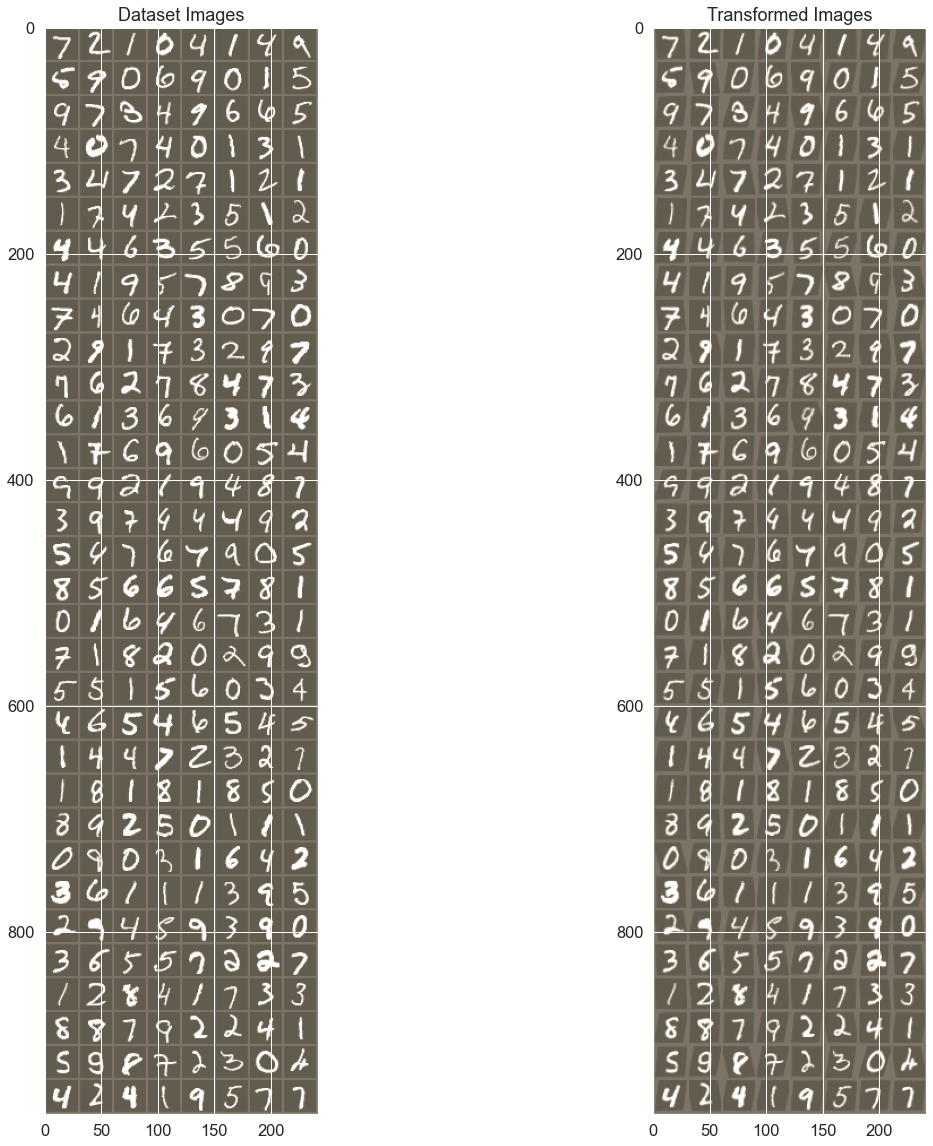

In [16]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data

        input_tensor = test_features.cpu()
        transformed_input_tensor = act.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2,figsize=(20,20))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images') 
        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')



# Visualize the STN transformation on some input batch
visualize_stn()
#wandb.log({'Final':wandb.Image(visualize_stn)})

plt.ioff()
plt.show()

In [16]:
@torch.no_grad()
def predict(dataloader, model, laplace=False):
    py = []
    target = []
    for x, t in dataloader:
        x,t = x.to(device),t.to(device)
        target.append(t)
        if laplace:
            py.append(model(x))
        else:
            py.append(torch.softmax(model(x), dim=-1))

    images = torch.cat(py).cpu()
    labels =torch.cat(target, dim=0).cpu()
    acc_map = (images.argmax(-1) == labels).float().mean()
    ece_map = ECE(bins=15).measure(images.numpy(), labels.numpy())
    nll_map = -dists.Categorical(images).log_prob(labels).mean()
    
    return acc_map,ece_map,nll_map

# Last Layer Implementation

## Without Laplace

In [21]:
acc_map,ece_map,nll_map = predict(test_loader,model,laplace=False)
print(f"[MAP] Acc.: {acc_map:.1%}; ECE: {ece_map:.1%}; NLL: {nll_map:.3}")


[MAP] Acc.: 99.4%; ECE: 0.3%; NLL: 0.0202


## With Laplace

In [17]:
%load_ext autoreload
%autoreload 2
la = Laplace(model, 'classification',
             subset_of_weights='last_layer',
             hessian_structure='kron')
la.fit(train_loader)
la.optimize_prior_precision(method='marglik')

start laplace


/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [19]:
acc_laplace,ece_laplace,nll_laplace = predict(test_loader, la, laplace=True)

print(
        f"[Laplace] Acc.: {acc_laplace:.1%}; ECE: {ece_laplace:.1%}; NLL: {nll_laplace:.3}"
    )

posterior predictive distribution line 523 baselaplace
get glm predictive distribution line 531
glm predictive distirbution
posterior predictive distribution line 523 baselaplace
get glm predictive distribution line 531
glm predictive distirbution
posterior predictive distribution line 523 baselaplace
get glm predictive distribution line 531
glm predictive distirbution
posterior predictive distribution line 523 baselaplace
get glm predictive distribution line 531
glm predictive distirbution
posterior predictive distribution line 523 baselaplace
get glm predictive distribution line 531
glm predictive distirbution
posterior predictive distribution line 523 baselaplace
get glm predictive distribution line 531
glm predictive distirbution
posterior predictive distribution line 523 baselaplace
get glm predictive distribution line 531
glm predictive distirbution
posterior predictive distribution line 523 baselaplace
get glm predictive distribution line 531
glm predictive distirbution
posterio

In [29]:
la(torch.ones(1,1,28,28))

posterior predictive distribution line 523 baselaplace
get glm predictive distribution line 531
glm predictive distirbution


tensor([[0.0148, 0.0292, 0.0674, 0.0046, 0.0529, 0.0231, 0.0166, 0.0138, 0.7203,
         0.0574]])

In [18]:
with torch.no_grad():
    py_la = []
    py=[]
    target_la = []
    target=[]
    test_image = []
    #temp= []
    for x, t in test_loader:
        x,t = x.to(device),t.to(device)
        target.append(t)
        test_image.append(x)
        target_la.append(t)
        py_la.append(la(x,pred_type='nn'))
        py.append(torch.softmax(model(x), dim=-1))

    images = torch.cat(py).cpu()
    labels =torch.cat(target, dim=0).cpu()
    images_la = torch.cat(py_la).cpu()
    labels_la =torch.cat(target_la, dim=0).cpu()
    acc_map = (images_la.argmax(-1) == labels_la).float().mean()
    ece_map = ECE(bins=15).measure(images_la.numpy(), labels_la.numpy())
    nll_map = -dists.Categorical(images_la).log_prob(labels_la).mean()
    


posterior predictive distribution line 523 baselaplace
get nn predictive samples
la kron sample
posterior predictive distribution line 523 baselaplace
get nn predictive samples
la kron sample
posterior predictive distribution line 523 baselaplace
get nn predictive samples
la kron sample
posterior predictive distribution line 523 baselaplace
get nn predictive samples
la kron sample
posterior predictive distribution line 523 baselaplace
get nn predictive samples
la kron sample
posterior predictive distribution line 523 baselaplace
get nn predictive samples
la kron sample
posterior predictive distribution line 523 baselaplace
get nn predictive samples
la kron sample
posterior predictive distribution line 523 baselaplace
get nn predictive samples
la kron sample
posterior predictive distribution line 523 baselaplace
get nn predictive samples
la kron sample
posterior predictive distribution line 523 baselaplace
get nn predictive samples
la kron sample
posterior predictive distribution line 5

In [19]:
uncertain_images = []
for i in range(len(test_loader.dataset)):
    vla,pla = torch.max(images_la[i],-1)
    v,p= torch.max(images[i],-1)
    if abs(vla-v)>0.1:
        uncertain_images.append(i)
        print(f'image {i} \n prob{v} class{p} \n la prob{vla} and la class{pla}')

image 247 
 prob0.8242112398147583 class6 
 la prob0.700491726398468 and la class6
image 259 
 prob0.9065146446228027 class0 
 la prob0.7833662629127502 and la class0
image 326 
 prob0.986831784248352 class2 
 la prob0.8583757877349854 and la class2
image 449 
 prob0.8860401511192322 class3 
 la prob0.7545059323310852 and la class3
image 674 
 prob0.8939769864082336 class5 
 la prob0.76923668384552 and la class5
image 1014 
 prob0.9419877529144287 class5 
 la prob0.8318448662757874 and la class5
image 1112 
 prob0.6724588871002197 class6 
 la prob0.5296669602394104 and la class6
image 1182 
 prob0.9407817125320435 class6 
 la prob0.8316532373428345 and la class6
image 1247 
 prob0.8908448815345764 class9 
 la prob0.750744640827179 and la class9
image 1260 
 prob0.7985249757766724 class7 
 la prob0.6932808756828308 and la class7
image 1299 
 prob0.8851649165153503 class7 
 la prob0.7540228366851807 and la class7
image 1319 
 prob0.9715798497200012 class8 
 la prob0.8605322241783142 and 

In [22]:
torch.max(images[1000],-1)

torch.return_types.max(
values=tensor(1.0000),
indices=tensor(7))

In [182]:
# def compute_entropy(preds):
#     return -torch.mean((torch.log2(preds + 1e-10) * preds).sum(dim=1)).item()

In [34]:
py_la[0].shape

torch.Size([256, 10])

In [20]:
test = torch.cat(test_image)

In [21]:
preds = la.predictive_samples(test,pred_type='nn',n_samples=100)

la predictive samples nn
get nn predictive samples
la kron sample


use the mean on the posterior samples to get the predictive posterior 

In [25]:
preds[1]

tensor([[1.0696e-13, 4.5135e-11, 3.3320e-10,  ..., 1.0000e+00, 1.9917e-13,
         1.0345e-08],
        [2.5293e-10, 5.6697e-10, 1.0000e+00,  ..., 1.2170e-10, 1.1664e-09,
         5.1637e-12],
        [2.7717e-11, 1.0000e+00, 1.5562e-10,  ..., 5.9701e-10, 2.6209e-10,
         1.1955e-10],
        ...,
        [1.0261e-14, 8.4931e-13, 1.0549e-13,  ..., 2.2118e-13, 8.6630e-10,
         2.7249e-11],
        [4.9897e-10, 5.3358e-13, 2.8806e-14,  ..., 2.0398e-14, 1.8638e-05,
         1.1106e-08],
        [5.0627e-11, 9.1819e-16, 1.0642e-11,  ..., 2.9535e-20, 1.2524e-11,
         2.1164e-14]])

In [35]:
py_la

[]

In [26]:
preds.shape

torch.Size([100, 10000, 10])

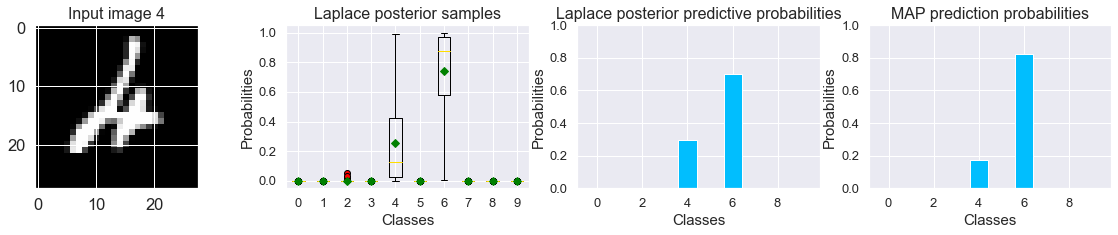

<Figure size 1008x720 with 0 Axes>

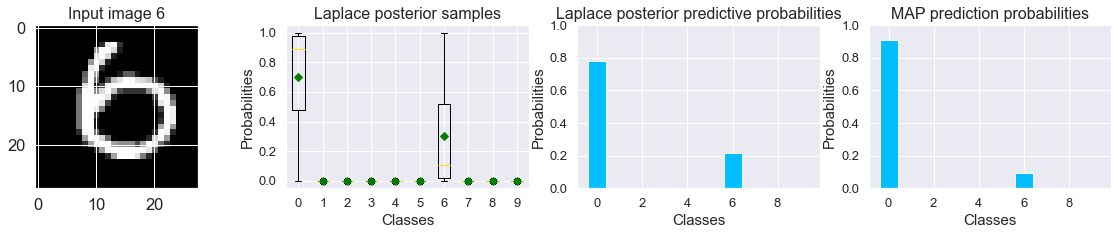

<Figure size 1008x720 with 0 Axes>

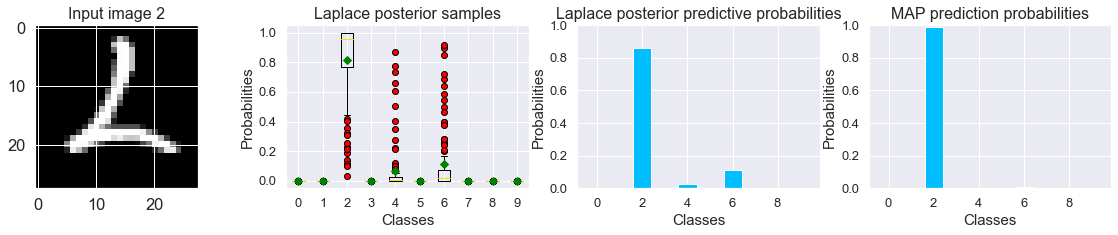

<Figure size 1008x720 with 0 Axes>

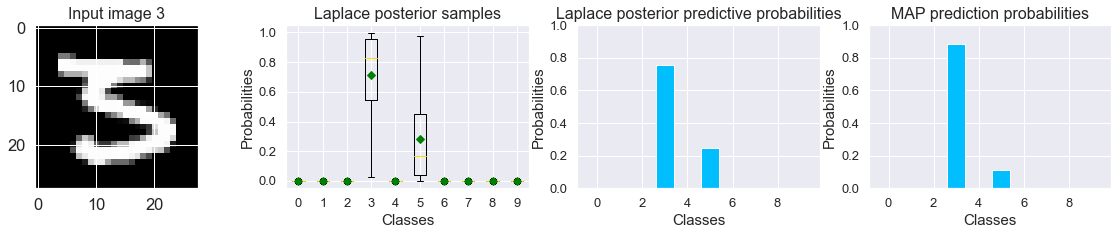

<Figure size 1008x720 with 0 Axes>

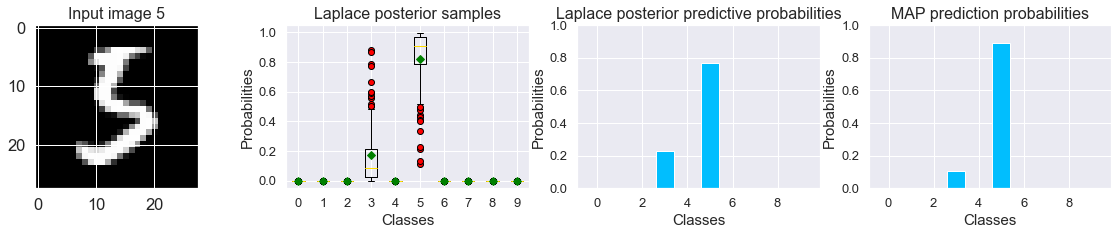

<Figure size 1008x720 with 0 Axes>

In [27]:
#get samples

if len(uncertain_images)==0:
    sample = random.sample(range(1, len(test_loader.dataset)), 5)
else:
    sample = uncertain_images[:5]

for i in range(len(sample)):
    fig,ax = plt.subplots(1,4, figsize=(20,3))
    img = test[sample[i]].squeeze()
    label = labels[sample[i]]

    #plots
    ax[0].imshow(img, cmap="gray")
    # for j in range(0,preds.shape[0]):
    #     ax[1].bar(range(preds.shape[2]), preds[j][sample[i]].cpu().detach().numpy(), alpha=0.2, color = 'grey')
    #     ax[1].set_ylim([0, 1])
    red_circle = dict(markerfacecolor='red', marker='o')
    mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
    ax[1].boxplot(preds[:,sample[i]].cpu().detach().numpy(),vert = True, flierprops =red_circle,showmeans=True, meanprops=mean_shape)
    ax[1].set_xticklabels(['0', '1','2', '3','4','5','6','7','8','9'])

    ax[2].bar(range(10),images_la[sample[i]].detach().numpy())

    ax[2].set_ylim([0,1])

    ax[3].bar(range(10),images[sample[i]].detach().numpy())
    ax[3].set_ylim([0,1])

    #titles
    ax[0].set_title(f'Input image {label}',size=16)
    ax[1].set_title('Laplace posterior samples',size=16)
    ax[2].set_title('Laplace posterior predictive probabilities',size=16)
    ax[3].set_title('MAP prediction probabilities',size=16)


    ax[1].set_ylabel('Probabilities',size=15)
    ax[2].set_ylabel('Probabilities',size=15)
    ax[3].set_ylabel('Probabilities',size=15)

    ax[1].set_xlabel('Classes',size=15)
    ax[2].set_xlabel('Classes',size=15)
    ax[3].set_xlabel('Classes',size=15)
    ax[1].tick_params(axis='both', labelsize=13)
    ax[2].tick_params(axis='both', labelsize=13)
    ax[3].tick_params(axis='both', labelsize=13)


    plt.show()
    plt.subplots_adjust(left=0.5, bottom=1, right=1.5, top=2, wspace=0.5, hspace=0.5)

fig.tight_layout()


In [26]:
def get_uncertainty_per_image(model, input_image, T=15, normalized=False):
    input_image = input_image#.unsqueeze(0)
    input_images = input_image.repeat(T, 1, 1, 1)

    net_out = model(input_images)
    pred = torch.mean(net_out, dim=0).cpu().detach().numpy()
    if normalized:
        prediction = F.softplus(net_out)
        p_hat = prediction / torch.sum(prediction, dim=1).unsqueeze(1)
    else:
        p_hat = F.softmax(net_out, dim=1)
    p_hat = p_hat.detach().cpu().numpy()
    p_bar = np.mean(p_hat, axis=0)

    temp = p_hat - np.expand_dims(p_bar, 0)
    epistemic = np.dot(temp.T, temp) / T
    epistemic = np.diag(epistemic)

    aleatoric = np.diag(p_bar) - (np.dot(p_hat.T, p_hat) / T)
    aleatoric = np.diag(aleatoric)

    return pred, epistemic, aleatoric

In [27]:
def get_sample(dataloader, sample_type='mnist'):
    idx = np.random.randint(len(dataloader.dataset))
    if sample_type=='mnist':
        sample = dataloader.dataset[idx][0]
        truth = dataloader.dataset[idx][1]
    

    sample = sample.unsqueeze(0)
    return sample.to(device), truth

In [29]:
import pandas as pd

posterior predictive distribution line 523 baselaplace
get glm predictive distribution line 531
glm predictive distirbution
posterior predictive distribution line 523 baselaplace
get glm predictive distribution line 531
glm predictive distirbution
   epistemic_norm  aleatoric_norm  epistemic_soft  aleatoric_soft  category  \
0    2.220446e-16        0.083363    0.000000e+00        0.078055         0   
1    5.551115e-17        0.083363    8.881784e-16        0.078055         1   
2    5.551115e-17        0.083363    2.220446e-16        0.078055         2   
3    5.551115e-17        0.083363    4.996004e-16        0.078055         3   
4    8.881784e-16        0.143660    8.881784e-16        0.178156         4   
5    5.551115e-17        0.083363    8.881784e-16        0.078055         5   
6    2.220446e-16        0.083363    0.000000e+00        0.078055         6   
7    5.551115e-17        0.083363    5.551115e-17        0.078055         7   
8    5.551115e-17        0.083363    5.55

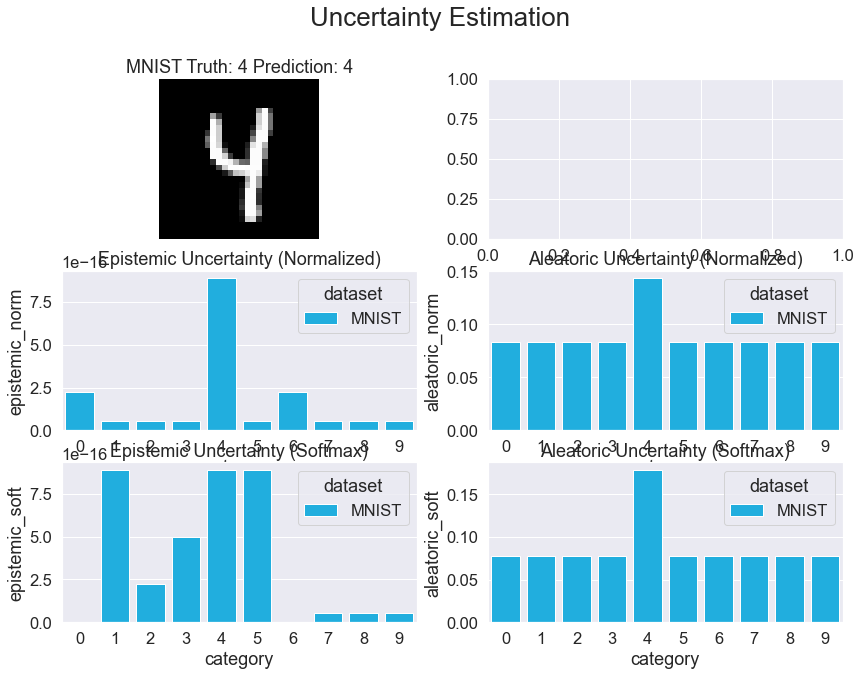

In [30]:



fig = plt.figure()
fig.suptitle('Uncertainty Estimation', fontsize='x-large')
mnist_img = fig.add_subplot(321)
notmnist_img = fig.add_subplot(322)
epi_stats_norm = fig.add_subplot(323)
ale_stats_norm = fig.add_subplot(324)
epi_stats_soft = fig.add_subplot(325)
ale_stats_soft = fig.add_subplot(326)

sample_mnist, truth_mnist = get_sample(train_loader.dataset)
pred_mnist, epi_mnist_norm, ale_mnist_norm = get_uncertainty_per_image(la, sample_mnist, T=25, normalized=True)
pred_mnist, epi_mnist_soft, ale_mnist_soft = get_uncertainty_per_image(la, sample_mnist, T=25, normalized=False)
mnist_img.imshow(sample_mnist.squeeze().cpu(), cmap='gray')
mnist_img.axis('off')
mnist_img.set_title('MNIST Truth: {} Prediction: {}'.format(int(truth_mnist), int(np.argmax(pred_mnist))))



x = list(range(10))
data = pd.DataFrame({
    'epistemic_norm': np.hstack([epi_mnist_norm]),
    'aleatoric_norm': np.hstack([ale_mnist_norm]),
    'epistemic_soft': np.hstack([epi_mnist_soft]),
    'aleatoric_soft': np.hstack([ale_mnist_soft]),
    'category': np.hstack([x]),
    'dataset': np.hstack([['MNIST']*10])
})
print(data)
sns.barplot(x='category', y='epistemic_norm', hue='dataset', data=data, ax=epi_stats_norm)
sns.barplot(x='category', y='aleatoric_norm', hue='dataset', data=data, ax=ale_stats_norm)
epi_stats_norm.set_title('Epistemic Uncertainty (Normalized)')
ale_stats_norm.set_title('Aleatoric Uncertainty (Normalized)')

sns.barplot(x='category', y='epistemic_soft', hue='dataset', data=data, ax=epi_stats_soft)
sns.barplot(x='category', y='aleatoric_soft', hue='dataset', data=data, ax=ale_stats_soft)
epi_stats_soft.set_title('Epistemic Uncertainty (Softmax)')
ale_stats_soft.set_title('Aleatoric Uncertainty (Softmax)')

plt.show()

# Subnetwork Laplace

In [16]:


subnetwork_mask = ModuleNameSubnetMask(model, module_names=['stn.fc_loc.0'])

subnetwork_mask.select()

subnetwork_indices = subnetwork_mask.indices

sub_la = Laplace(
    model,
    "classification",
    subset_of_weights="subnetwork",
    hessian_structure="full",
    subnetwork_indices = subnetwork_indices#.type(torch.LongTensor),
)

sub_la.fit(train_loader)
#print('optimize')
#sub_la.prior_precision=torch.tensor([0.0001])

#la.optimize_prior_precision(method="marglik")






start laplace


/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.Net'> although the module has parameters
  warnings.warn(
/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.Base'> although the module has parameters
  warnings.warn(
/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesia

In [17]:
def sample_predictions(ma,lap,device,dataloader):
    with torch.no_grad():
        py_la = []
        py=[]
        target_la = []
        target=[]
        test_image = []
        #temp= []
        for x, t in dataloader:
            x,t = x.to(device),t.to(device)
            target.append(t)
            test_image.append(x)
            target_la.append(t)
            py_la.append(lap(x,pred_type='nn'))
            py.append(torch.softmax(ma(x), dim=-1))

        images = torch.cat(py).cpu()
        labels =torch.cat(target, dim=0).cpu()
        images_la = torch.cat(py_la).cpu()
        labels_la =torch.cat(target_la, dim=0).cpu()
        return images,labels,images_la,labels_la,test_image
    
    

In [18]:
images_sub,labels_sub,images_sub_la,labels_sub_la,test_sub_image = sample_predictions(model,sub_la,device,test_loader)

posterior predictive distribution line 523 baselaplace
predictive samples line 605 baselaplace
subnet samples
posterior predictive distribution line 523 baselaplace
predictive samples line 605 baselaplace
subnet samples
posterior predictive distribution line 523 baselaplace
predictive samples line 605 baselaplace
subnet samples
posterior predictive distribution line 523 baselaplace
predictive samples line 605 baselaplace
subnet samples
posterior predictive distribution line 523 baselaplace
predictive samples line 605 baselaplace
subnet samples
posterior predictive distribution line 523 baselaplace
predictive samples line 605 baselaplace
subnet samples
posterior predictive distribution line 523 baselaplace
predictive samples line 605 baselaplace
subnet samples
posterior predictive distribution line 523 baselaplace
predictive samples line 605 baselaplace
subnet samples
posterior predictive distribution line 523 baselaplace
predictive samples line 605 baselaplace
subnet samples
posterior 

In [19]:
uncertain_images = []
for i in range(len(test_loader.dataset)):
    vla,pla = torch.max(images_sub_la[i],-1)
    v,p= torch.max(images_sub[i],-1)
    if abs(vla-v)>0.1:
        uncertain_images.append(i)
        #print(f'image {i} \n prob{v} class{p} \n la prob{vla} and la class{pla}')

In [20]:
len(uncertain_images)

5384

In [21]:
%load_ext autoreload
%autoreload 2
test = torch.cat(test_sub_image)
preds = sub_la.predictive_samples(test,pred_type='nn',n_samples=100)

la predictive samples nn
predictive samples line 605 baselaplace
subnet samples


In [24]:
sample=uncertain_images[:5]

preds[:,sample[0],:].mean()

tensor(0.1000)

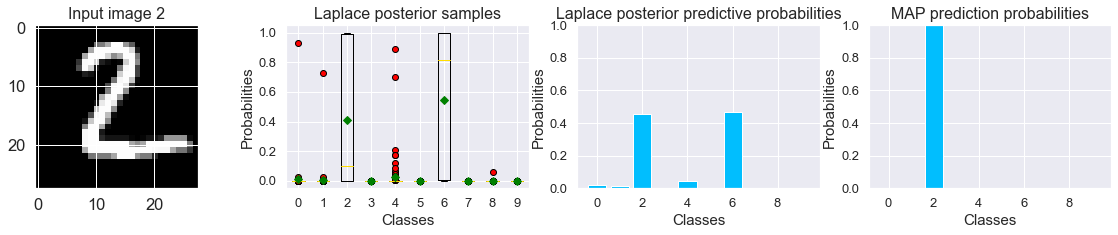

<Figure size 1008x720 with 0 Axes>

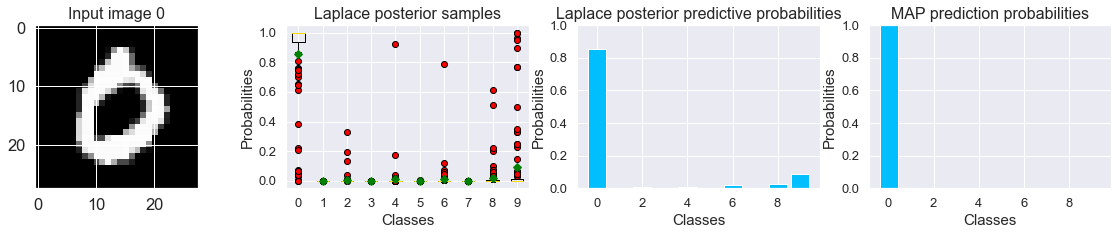

<Figure size 1008x720 with 0 Axes>

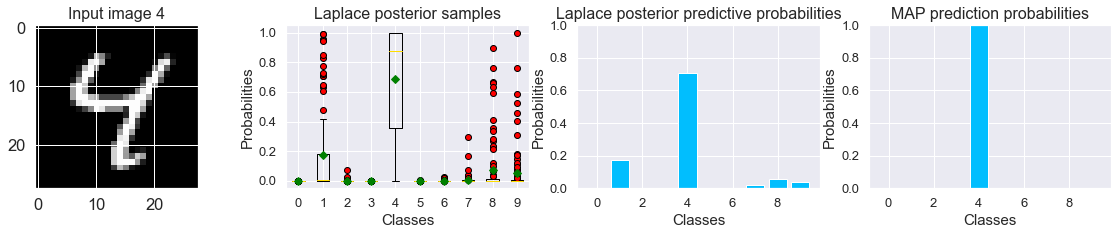

<Figure size 1008x720 with 0 Axes>

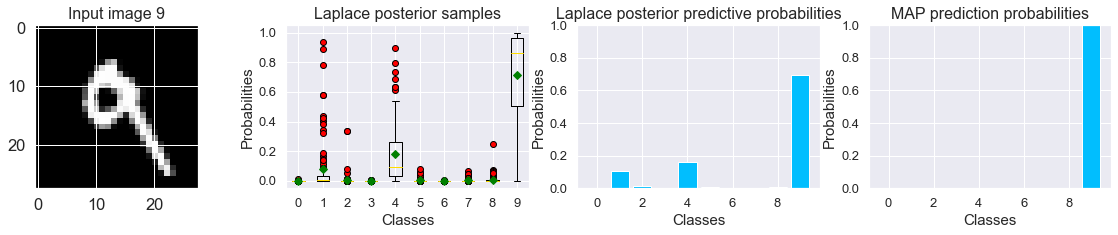

<Figure size 1008x720 with 0 Axes>

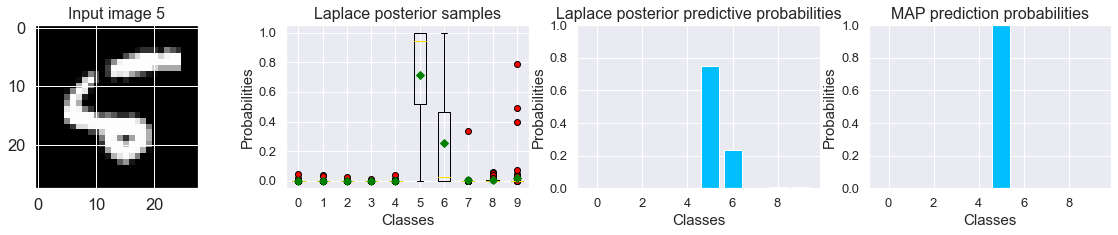

<Figure size 1008x720 with 0 Axes>

In [23]:
sample=uncertain_images[:5]
for i in range(len(sample)):
    fig,ax = plt.subplots(1,4, figsize=(20,3))
    img = test[sample[i]].squeeze()
    label = labels_sub_la[sample[i]]

    #plots
    ax[0].imshow(img, cmap="gray")
    #for j in range(0,preds.shape[0]):
        #ax[1].boxplot([range(preds.shape[2]), preds[j][sample[i]].cpu().detach().numpy()])
        #ax[1].set_ylim([0, 1])
    red_circle = dict(markerfacecolor='red', marker='o')
    mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
    ax[1].boxplot(preds[:,sample[i],:].cpu().detach().numpy(),vert = True, flierprops =red_circle,showmeans=True, meanprops=mean_shape)
    ax[1].set_xticklabels(['0', '1','2', '3','4','5','6','7','8','9'])
    ax[2].bar(range(10),images_sub_la[sample[i]].detach().numpy())
    #ax[2].bar(range(10),preds[:,sample[i]].mean())#.detach().numpy())


    ax[2].set_ylim([0,1])

    ax[3].bar(range(10),images_sub[sample[i]].detach().numpy())
    ax[3].set_ylim([0,1])

    #titles
    ax[0].set_title(f'Input image {label}',size=16)
    ax[1].set_title('Laplace posterior samples',size=16)
    ax[2].set_title('Laplace posterior predictive probabilities',size=16)
    ax[3].set_title('MAP prediction probabilities',size=16)


    ax[1].set_ylabel('Probabilities',size=15)
    ax[2].set_ylabel('Probabilities',size=15)
    ax[3].set_ylabel('Probabilities',size=15)

    ax[1].set_xlabel('Classes',size=15)
    ax[2].set_xlabel('Classes',size=15)
    ax[3].set_xlabel('Classes',size=15)
    ax[1].tick_params(axis='both', labelsize=13)
    ax[2].tick_params(axis='both', labelsize=13)
    ax[3].tick_params(axis='both', labelsize=13)


    plt.show()
    plt.subplots_adjust(left=0.5, bottom=1, right=1.5, top=2, wspace=0.5, hspace=0.5)

fig.tight_layout()

In [26]:
#sub_la.prior_precision=torch.tensor([10000])

subnet_samples= sub_la.sample(n_samples=10)

subnet samples


In [27]:
subnet_samples.shape

torch.Size([10, 47108])

In [74]:
data = next(iter(test_loader))[0]

In [60]:
sample=uncertain_images[:5]

subnet_samples[:,sample[0]]

tensor([0.0368, 0.0368, 0.0368, 0.0368, 0.0368, 0.0368, 0.0368, 0.0368, 0.0368,
        0.0368])

In [65]:
data[sample[0]].unsqueeze(0).squeeze().shape

torch.Size([28, 28])

subnet samples


TypeError: Invalid shape (0, 1, 28, 28) for image data

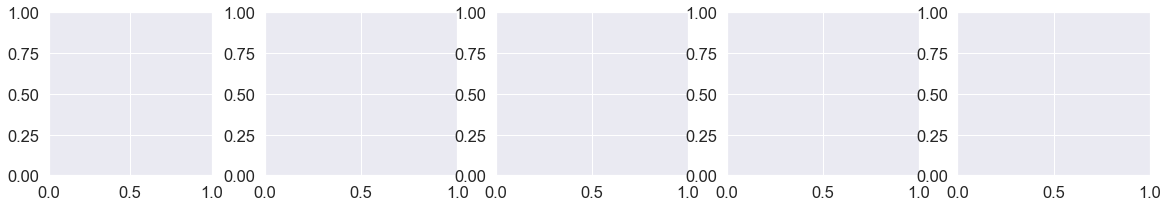

In [76]:
fig,ax = plt.subplots(1,5, figsize=(20,3))

images=uncertain_images[:5]
subnet_samples= sub_la.sample(n_samples=10)
for i,sample in enumerate(subnet_samples[:5]):    
    torch.nn.utils.vector_to_parameters(sample, model.parameters())
    img = data[:i,:].cpu()
    #label = labels_sub_la[images[i]]
    #transformation = model.stn(data[:i,:].unsqueeze(0))
    #out = convert_image_np(transformation)
    #print(out.shape)


    ax[0].imshow(img, cmap="gray")
    #ax[i].imshow(transformation.squeeze().cpu().detach().numpy(),cmap="gray")


In [51]:
data = next(iter(test_loader))[0]

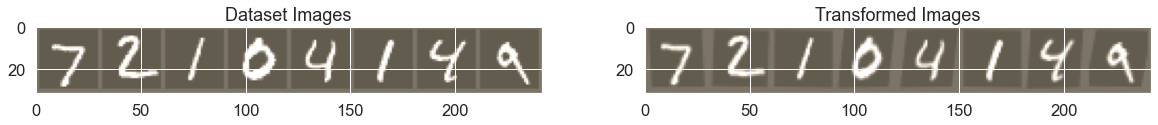

In [20]:
with torch.no_grad():
    # Get a batch of training data

    input_tensor = data[:8,:].cpu()
    transformed_input_tensor = model.stn(data[:8,:].cpu())

    in_grid = convert_image_np(
        torchvision.utils.make_grid(input_tensor))

    out_grid = convert_image_np(
        torchvision.utils.make_grid(transformed_input_tensor))

    # Plot the results side-by-side
    f, axarr = plt.subplots(1, 2,figsize=(20,20))
    axarr[0].imshow(in_grid)
    axarr[0].set_title('Dataset Images') 
    axarr[1].imshow(out_grid)
    axarr[1].set_title('Transformed Images')



# Visualize the STN transformation on some input batch
#wandb.log({'Final':wandb.Image(visualize_stn)})

plt.ioff()
plt.show()

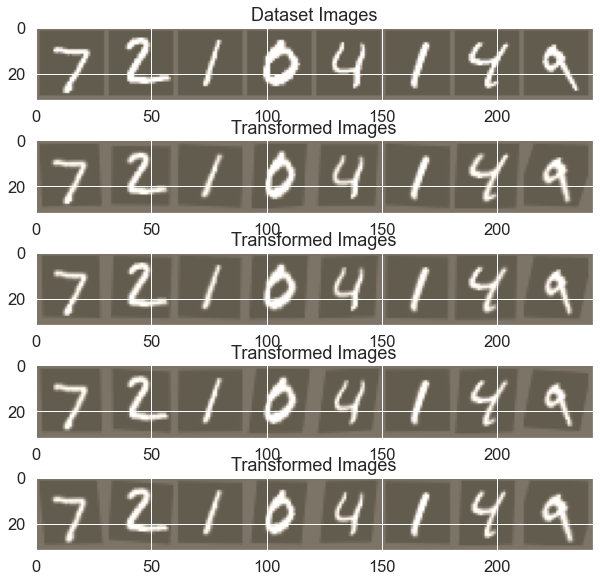

In [19]:
#fc_loc.2
f, axarr = plt.subplots(5, 1,figsize=(10,10))
#data  = next(iter(test_loader))[0]
input_tensor = data[:8,:].cpu()
in_grid = convert_image_np(
    torchvision.utils.make_grid(input_tensor))



for i,sample in enumerate(subnet_samples[:5]):
    torch.nn.utils.vector_to_parameters(sample, model.parameters())
    transformed_input_tensor = model.stn(data[:8,:].to(device))
    out_grid = convert_image_np(
        torchvision.utils.make_grid(transformed_input_tensor))
#Plot the results side-by-side
    axarr[0].imshow(in_grid)
    axarr[0].set_title('Dataset Images')

    axarr[i].imshow(out_grid)
    axarr[i].set_title('Transformed Images')





/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


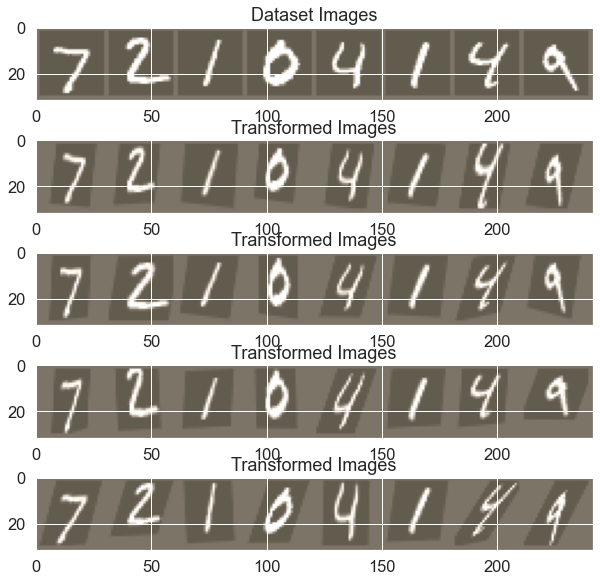

In [77]:
#fc_loc.0
f, axarr = plt.subplots(5, 1,figsize=(10,10))
#data  = next(iter(test_loader))[0]
input_tensor = data[:8,:].cpu()
in_grid = convert_image_np(
    torchvision.utils.make_grid(input_tensor))



for i,sample in enumerate(subnet_samples[:5]):
    torch.nn.utils.vector_to_parameters(sample, model.parameters())
    transformed_input_tensor = model.stn(data[:8,:].to(device))
    out_grid = convert_image_np(
        torchvision.utils.make_grid(transformed_input_tensor))
#Plot the results side-by-side
    axarr[0].imshow(in_grid)
    axarr[0].set_title('Dataset Images')

    axarr[i].imshow(out_grid)
    axarr[i].set_title('Transformed Images')


/Users/georgioszefkilis/anaconda3/anaconda3/envs/Bayesian_DL/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


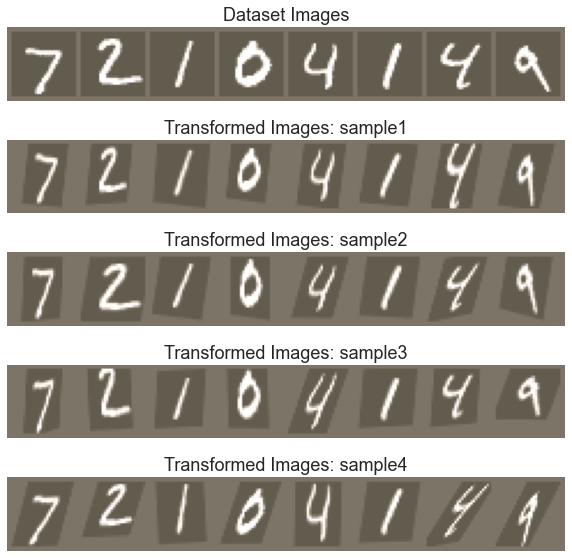

In [111]:
#fc_loc.0,fc_loc.2
f, axarr = plt.subplots(5, 1,figsize=(10,10))
#data  = next(iter(test_loader))[0]
input_tensor = data[:8,:].cpu()
in_grid = convert_image_np(
    torchvision.utils.make_grid(input_tensor))



for i,sample in enumerate(subnet_samples[:5]):
    torch.nn.utils.vector_to_parameters(sample, model.parameters())
    transformed_input_tensor = model.stn(data[:8,:].to(device))
    out_grid = convert_image_np(
        torchvision.utils.make_grid(transformed_input_tensor))
#Plot the results side-by-side
    axarr[0].imshow(in_grid)
    axarr[0].set_title('Dataset Images')

    axarr[i].imshow(out_grid)
    axarr[i].set_title(f'Transformed Images: sample {i}')
    axarr[i].set_axis_off()
plt.show()
f.tight_layout()

In [86]:
data[:1,:].shape

torch.Size([1, 1, 28, 28])

In [85]:
test[uncertain_images[0]].shape

torch.Size([1, 28, 28])

In [87]:
sample=test[:8]


In [89]:
len(sample)

8

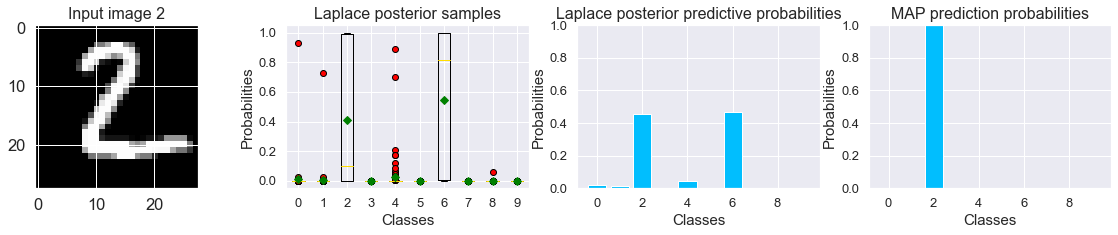

<Figure size 1008x720 with 0 Axes>

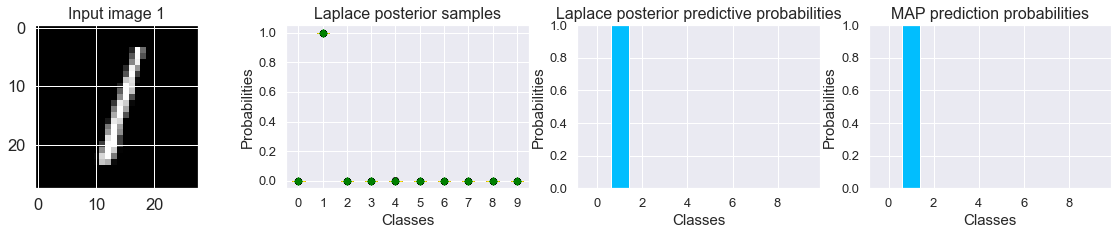

<Figure size 1008x720 with 0 Axes>

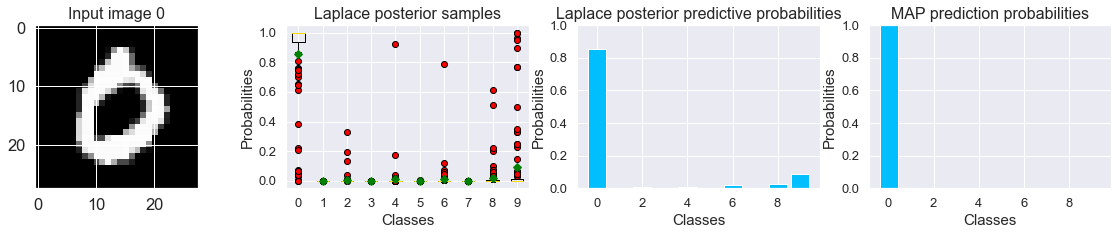

<Figure size 1008x720 with 0 Axes>

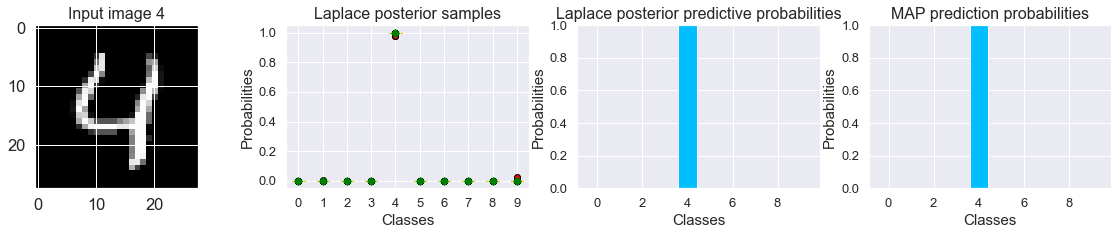

<Figure size 1008x720 with 0 Axes>

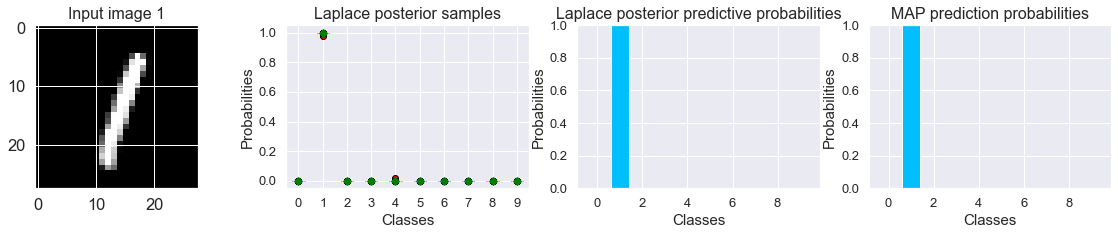

<Figure size 1008x720 with 0 Axes>

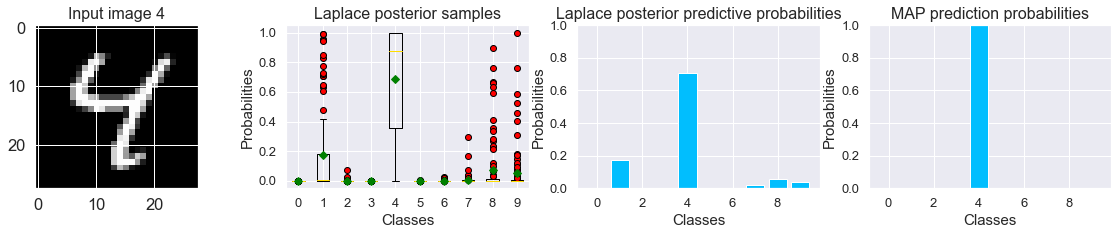

<Figure size 1008x720 with 0 Axes>

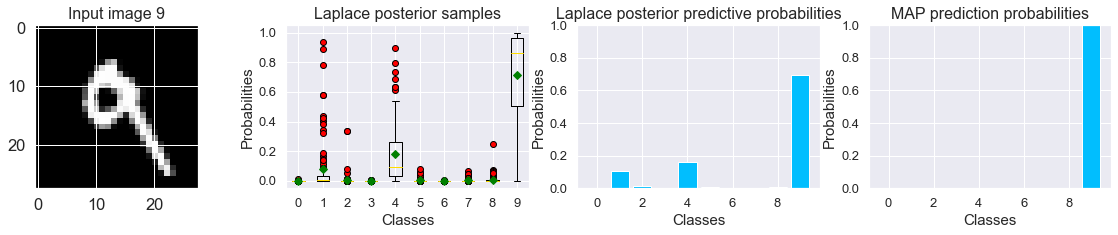

<Figure size 1008x720 with 0 Axes>

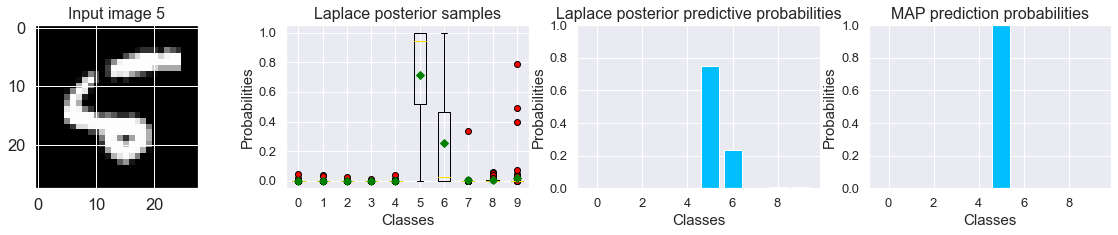

<Figure size 1008x720 with 0 Axes>

In [98]:
sample=[1,2,3,4,5,6,7,8]
for i in range(len(sample)):
    fig,ax = plt.subplots(1,4, figsize=(20,3))
    img = data[sample[i]].squeeze()
    label = labels_sub_la[sample[i]]

    #plots
    ax[0].imshow(img, cmap="gray")
    #for j in range(0,preds.shape[0]):
        #ax[1].boxplot([range(preds.shape[2]), preds[j][sample[i]].cpu().detach().numpy()])
        #ax[1].set_ylim([0, 1])
    red_circle = dict(markerfacecolor='red', marker='o')
    mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
    ax[1].boxplot(preds[:,sample[i],:].cpu().detach().numpy(),vert = True, flierprops =red_circle,showmeans=True, meanprops=mean_shape)
    ax[1].set_xticklabels(['0', '1','2', '3','4','5','6','7','8','9'])
    ax[2].bar(range(10),images_sub_la[sample[i]].detach().numpy())
    #ax[2].bar(range(10),preds[:,sample[i]].mean())#.detach().numpy())


    ax[2].set_ylim([0,1])

    ax[3].bar(range(10),images_sub[sample[i]].detach().numpy())
    ax[3].set_ylim([0,1])

    #titles
    ax[0].set_title(f'Input image {label}',size=16)
    ax[1].set_title('Laplace posterior samples',size=16)
    ax[2].set_title('Laplace posterior predictive probabilities',size=16)
    ax[3].set_title('MAP prediction probabilities',size=16)


    ax[1].set_ylabel('Probabilities',size=15)
    ax[2].set_ylabel('Probabilities',size=15)
    ax[3].set_ylabel('Probabilities',size=15)

    ax[1].set_xlabel('Classes',size=15)
    ax[2].set_xlabel('Classes',size=15)
    ax[3].set_xlabel('Classes',size=15)
    ax[1].tick_params(axis='both', labelsize=13)
    ax[2].tick_params(axis='both', labelsize=13)
    ax[3].tick_params(axis='both', labelsize=13)


    plt.show()
    plt.subplots_adjust(left=0.5, bottom=1, right=1.5, top=2, wspace=0.5, hspace=0.5)

fig.tight_layout()

In [22]:
def sanity_check_laplace(la,sublaplace,dataloader):

    priors = torch.tensor([0.01,1000])
    state = ['no_opt','prior','default']

    laplace_samples_default = []
    sublaplace_samples_default = []
    laplace_sample_priors = []
    sublaplace_sample_priors = []
    laplace_sample_no_opt = []
    la_acc=[]
    la_ece = []
    la_nll =[]
    subla_acc=[]
    subla_ece = []
    subla_nll =[]
    la_metrics = []
    sub_metrics=[]
    
    for i in range(len(state)):
        print(state[i])

        if state[i]=='no_opt':

            laplace = la.sample(n_samples=10)
            laplace_sample_no_opt.append(laplace)

            _,subset = sublaplace.sample(n_samples=10)
            sublaplace_samples_default.append(subset)

            acc_la,ece_la,nll_la = predict(dataloader, la, laplace=True)
            acc_sublaplace,ece_sublaplace,nll_sublaplace = predict(dataloader, sublaplace, laplace=True)
            la_acc.append(acc_la)
            la_ece.append(ece_la)
            la_nll.append(nll_la)
            subla_acc.append(acc_sublaplace)
            subla_ece.append(ece_sublaplace)
            subla_nll.append(nll_sublaplace)


        elif state[i]=='prior':
            for j in range(len(priors)):

                la.prior_precision = priors[j]
                sublaplace.prior_precision = priors[j]

                laplace = la.sample(n_samples=10)
                laplace_sample_priors.append(laplace)

                _,subset = sublaplace.sample(n_samples=10)
                sublaplace_sample_priors.append(subset)
                acc_la,ece_la,nll_la = predict(dataloader, la, laplace=True)
                acc_sublaplace,ece_sublaplace,nll_sublaplace = predict(dataloader, sublaplace, laplace=True)

                la_acc.append(acc_la)
                la_ece.append(ece_la)
                la_nll.append(nll_la)
                subla_acc.append(acc_sublaplace)
                subla_ece.append(ece_sublaplace)
                subla_nll.append(nll_sublaplace)

        elif state[i]=='default':

            la.optimize_prior_precision(method="marglik")
            laplace = la.sample(n_samples=10)

            laplace_samples_default.append(laplace)
            acc_la,ece_la,nll_la = predict(dataloader, la, laplace=True)
            la_acc.append(acc_la)
            la_ece.append(ece_la)
            la_nll.append(nll_la)
        else:
            pass
        
        
        la_metrics.append(la_acc)
        la_metrics.append(la_ece)
        la_metrics.append(la_nll)
        sub_metrics.append(subla_acc)
        sub_metrics.append(subla_ece)
        sub_metrics.append(subla_nll)




    return laplace_samples_default, sublaplace_samples_default,laplace_sample_priors ,sublaplace_sample_priors,laplace_sample_no_opt,la_metrics,sub_metrics

In [23]:
laplace_samples_default, sublaplace_samples_default,laplace_sample_priors ,sublaplace_sample_priors,laplace_sample_no_opt,la_metrics,sub_metrics=sanity_check_laplace(la,sub_la,test_loader)

no_opt
get_samples
get subnetwork samples
prior
get_samples
get subnetwork samples
get_samples
get subnetwork samples
default
Start optimization
get_samples


In [24]:
import pandas as pd

In [30]:
laplace_data = {
    'MAP':[f'{acc_map:.1%}',f'{ece_map:.1%}',f'{nll_map:.3}'],
    'Laplace optimization':[f'{la_metrics[0][3]:.1%}',f'{la_metrics[1][3]:.1%}',f'{la_metrics[2][3]:.3}'],
    'Laplace no optimization':[f'{la_metrics[0][0]:.1%}',f'{la_metrics[1][0]:.1%}',f'{la_metrics[2][0]:.3}'],
    'Laplace small prior':[f'{la_metrics[0][1]:.1%}',f'{la_metrics[1][1]:.1%}',f'{la_metrics[2][1]:.3}'],
    'Laplace large prior':[f'{la_metrics[0][2]:.1%}',f'{la_metrics[1][2]:.1%}',f'{la_metrics[2][2]:.3}'],
    'Subnetwork Laplace':[f'{sub_metrics[0][0]:.1%}',f'{sub_metrics[1][0]:.1%}',f'{sub_metrics[2][0]:.3}'],
    'Subnetwork Laplace small prior':[f'{sub_metrics[0][1]:.1%}',f'{sub_metrics[1][1]:.1%}',f'{sub_metrics[2][1]:.3}'],
    'Subnetwork Laplace large prior':[f'{sub_metrics[0][2]:.1%}',f'{sub_metrics[1][2]:.1%}',f'{sub_metrics[2][2]:.3}']

}
indices = ['Acc','ECE','NLL']
laplace_report = pd.DataFrame(laplace_data,index=indices)
laplace_report.to_csv('/Users/georgioszefkilis/Bayesian_Deep_Learning/reports/figures/STN_results.csv')
laplace_report


,MAP,Laplace optimization,Laplace no optimization,Laplace small prior,Laplace large prior,Subnetwork Laplace,Subnetwork Laplace small prior,Subnetwork Laplace large prior
Acc,99.4%,99.4%,99.4%,99.4%,99.4%,98.9%,98.9%,99.3%
ECE,0.3%,0.3%,14.5%,84.4%,0.3%,15.4%,64.0%,0.2%
NLL,0.0202,0.0199,0.175,1.9,0.0199,0.215,1.16,0.0198


In [26]:
lamargilk = laplace_samples_default[0][0].cpu().detach().numpy()
subdefault = sublaplace_samples_default[0][0].cpu().detach().numpy()
small = laplace_sample_priors[0][0].detach().cpu().numpy()
large = laplace_sample_priors[1][0].detach().cpu().numpy()
subsmall = sublaplace_sample_priors[0][0].detach().cpu().numpy()
sublarge = sublaplace_sample_priors[1][0].detach().cpu().numpy()
no_opt = laplace_sample_no_opt[0][0].detach().cpu().numpy()

In [27]:
module ='stn 1,2'

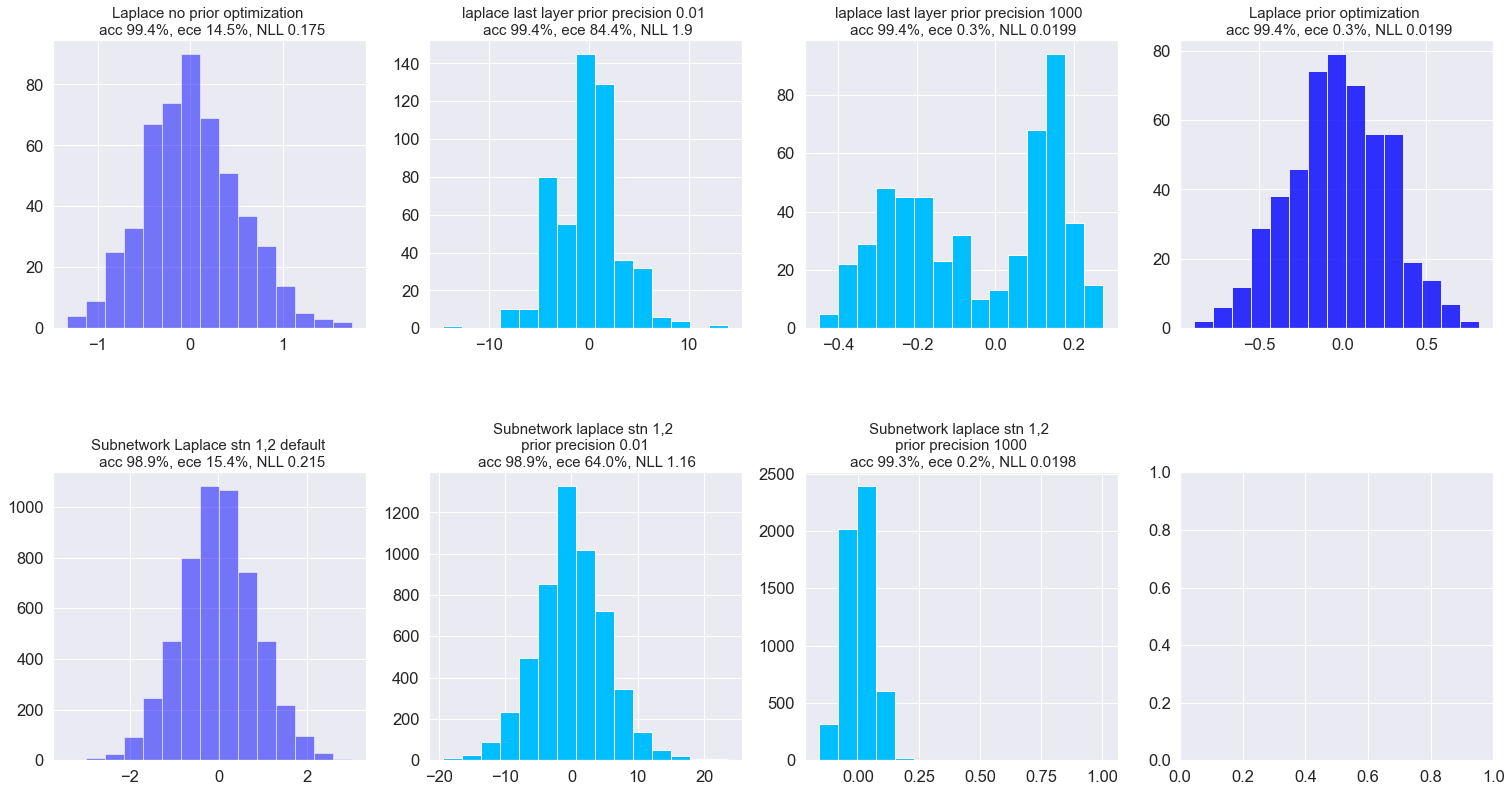

In [28]:
fig, axes = plt.subplots(nrows=2,ncols = 4 , sharey=False,figsize=(20,10))

#laplace plots
axes[0,0].hist(no_opt,bins=15,facecolor='blue', alpha=0.5)
axes[0,1].hist(small,bins=15)
axes[0,2].hist(large,bins=15)
axes[0,3].hist(lamargilk,bins=15,facecolor='blue', alpha=0.8)


#subnetwrok laplace
axes[1,0].hist(subdefault,bins=15,facecolor='blue', alpha=0.5)
axes[1,1].hist(subsmall,bins=15)
axes[1,2].hist(sublarge,bins=15)

axes[0,0].set_title(f'Laplace no prior optimization \n acc {la_metrics[0][0]:.1%}, ece {la_metrics[1][0]:.1%}, NLL {la_metrics[2][0]:.3}',size=15)
axes[0,1].set_title(f'laplace last layer prior precision 0.01 \n acc {la_metrics[0][1]:.1%}, ece {la_metrics[1][1]:.1%}, NLL {la_metrics[2][1]:.3}',size=15)
axes[0,2].set_title(f'laplace last layer prior precision 1000 \n acc {la_metrics[0][2]:.1%}, ece {la_metrics[1][2]:.1%}, NLL {la_metrics[2][2]:.3}',size=15)
axes[0,3].set_title(f'Laplace prior optimization \n acc {la_metrics[0][3]:.1%}, ece {la_metrics[1][3]:.1%}, NLL {la_metrics[2][3]:.3}',size=15)


axes[1,0].set_title(f'Subnetwork Laplace {module} default \n acc {sub_metrics[0][0]:.1%}, ece {sub_metrics[1][0]:.1%}, NLL {sub_metrics[2][0]:.3}',size=15)
axes[1,1].set_title(f'Subnetwork laplace {module} \n prior precision 0.01 \n acc {sub_metrics[0][1]:.1%}, ece {sub_metrics[1][1]:.1%}, NLL {sub_metrics[2][1]:.3}',size=15)
axes[1,2].set_title(f'Subnetwork laplace {module} \n prior precision 1000 \n acc {sub_metrics[0][2]:.1%}, ece {sub_metrics[1][2]:.1%}, NLL {sub_metrics[2][2]:.3}',size=15)

plt.subplots_adjust(left=0.5, bottom=1, right=1.5, top=2, wspace=0.2, hspace=0.5)
plt.savefig('/Users/georgioszefkilis/Bayesian_Deep_Learning/reports/figures/STN_results.png',bbox_inches='tight')
plt.show()

fig.tight_layout()
